Covid-19_and_Pneumonia_X-Ray_Detector

In [ ]:
# Connect Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, cohen_kappa_score, recall_score, f1_score

In [ ]:
import cv2
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load, scale and prepare train sets
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [ ]:
import tensorflow_addons as tfa
from tensorflow_addons.metrics import CohenKappa
# from tensorflow_addons.losses import WeightedKappaLoss # ??? Ordinal?

In [ ]:
# resNet50
# from tensorflow.keras.applications.resnet50 import ResNet50
# ModuleNotFoundError: No module named 'tensorflow.keras.application'

# Functions

In [ ]:
def listdir_nohidden(path):
  """ returns a list of no hidden folders in a path
  in this case the folders are sorted as the are classes of a images
  (and later will be used as an iterator...)"""
  # import os

  folders = []
  for f in os.listdir(path):
    if not f.startswith('.'):
      # yield f # returns a generator (iterable)
      folders += [f]
  return sorted(folders)


In [ ]:
def plot_metric(history, metric):
    train_metrics = history.history[metric] # Get the error metric for the TRAIN set
    val_metrics = history.history['val_'+metric] # Get the error metric for the VALIDATION set
    epochs = range(1, len(train_metrics) + 1) # range(1,6) -> 1,2,3,4,5
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.yscale('log')
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

# Description

### Identify COVID by x-RAy  
Dectect and classify chest illneses.  
Reduce costs and detection time.  
Have a pre-diagnosis in minutes. Increase survival rate.  
Categories:  
* Healthy
* Covid-19
* Bacterial Pneumonia
* Viric Pneumonia   


### Data info
custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.Each class contains 133 images.  
  
data from https://github.com/ieee8023/covid-chestxray-dataset and https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia.  
created by frogames.    

0 - Covid-19

1 - Normal X-ray

2 - Viral Pneumonia X-ray

3 - Bacterial Pneumonia X-ray


# Load Data

In [ ]:
# !!! change dir
# allows to work with relative paths in all the notebook
os.chdir('/content/drive/MyDrive/ironhack-finalProject')

In [ ]:
train_path = 'data_train'

In [ ]:
# Scan folders in train_path
# os.listdir(train_path)
listdir_nohidden(train_path)

['0', '1', '2', '3']

In [ ]:
datagen_load = ImageDataGenerator(rescale = 1./255,
                                     validation_split = 0.2)

In [ ]:
# Question 
# ??? rescale --> I think it min_max_scale the values of the pixels in the image
# between 0 and 1


In [ ]:
load_generator = datagen_load.flow_from_directory(batch_size = 40,
                                                      directory = train_path,
                                                      seed = 0,
                                                      target_size = (256,256), # input size to the NN
                                                      # classes = ['covid', 'normal', 'viral', 'bacteria'],
                                                      class_mode = "categorical",
                                                      subset = "training")

Found 428 images belonging to 4 classes.


In [ ]:
# Question
# !!! flow_from_directory Deprecated?
# classes?

Deprecated: tf.keras.preprocessing.image.ImageDataGenerator is not recommended for new code. Prefer loading images with tf.keras.utils.image_dataset_from_directory and transforming the output tf.data.Dataset with preprocessing layers. For more information, see the tutorials for loading images and augmenting images, as well as the preprocessing layer guide.  
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

In [ ]:
# test_path = '/content/drive/MyDrive/ironhack-finalProject/data_test'

In [ ]:
# Define validation subset
# After validation split en image_generator
load_validation = datagen_load.flow_from_directory(batch_size = 40,
                                                      directory = train_path,
                                                      seed = 0,
                                                      target_size = (256,256), # input size to the NN
                                                      # classes = ['covid', 'normal', 'viral', 'bacteria'],
                                                      class_mode = "categorical",
                                                      subset = "validation")


Found 104 images belonging to 4 classes.


In [ ]:
# 133*4, 133*4*0.8, 133*4*0.2

In [ ]:
train_images, train_labels = next(load_generator)

In [ ]:
# Question
# ??? next?
# https://datascience.stackexchange.com/questions/88737/keras-next-what-does-2-256-128-128-3-mean

In [ ]:
# train_generator.shape

In [ ]:
train_images.shape

(40, 256, 256, 3)

In [ ]:
train_labels.shape

(40, 4)

In [ ]:
train_labels

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]],

In [ ]:
# We are assuming that is not possible to have two illneses at the same time

In [ ]:
label_names = {0:'covid', 1:'normal', 2: 'viral', 3:'bacterial'}

# Visualize images

In [ ]:
#L = 6
#W = 6
#range(L*W)

In [ ]:
"""
# Create matrix of images
L = 6
W = 6

fig, ax = plt.subplots(L, W, figsize = (12,12))
ax = ax.ravel() # it flattens the axes and allows to make a for loop

for i in range(L*W):
  ax[i].imshow(train_images[i])
  ax[i].set_title(label_names[np.argmax(train_labels[i])])
  ax[i].axis('off')

plt.subplots_adjust(wspace=0.5)
"""

"\n# Create matrix of images\nL = 6\nW = 6\n\nfig, ax = plt.subplots(L, W, figsize = (12,12))\nax = ax.ravel() # it flattens the axes and allows to make a for loop\n\nfor i in range(L*W):\n  ax[i].imshow(train_images[i])\n  ax[i].set_title(label_names[np.argmax(train_labels[i])])\n  ax[i].axis('off')\n\nplt.subplots_adjust(wspace=0.5)\n"

In [ ]:
# 120*5*5

# Build the CNN 0

## Convolutional architecture

In [ ]:
# Initialize the CNN
cls = Sequential()

In [ ]:
# Add Convolution Layer
# cls.add(Conv2D(32, (5,5), input_shape= (256,256,3), activation='relu', padding = 'valid' ))
cls.add(Conv2D(9, (5,5), input_shape= (256,256,3), activation='relu', padding = 'valid' ))

In [ ]:
# classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
# input shape necessary when not all the pictures are squared.

In [ ]:
# Question
# ??? padding, --> acolchado/ relleno en el input. if padding "same" and strides = 1
# then input size and output size will be the same
# ??? strides, --> zancadas o avances. i.e [i,2,2,1] (if window 2x2 no overlaping)
# ??? dilation_rate...

In [ ]:
# Add Max Pooling (spatial subsampling)
# Very important define well the pool_size
cls.add(MaxPool2D(pool_size = (2, 2), padding="valid"))
cls.add(MaxPool2D(pool_size = (2, 2), padding="valid"))

In [ ]:
# average pooling 
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D

In [ ]:
# Flattening
cls.add(Flatten())

## Fully-connected layers

In [ ]:
# Dense Layers
#cls.add(Dense(units = 256, activation = 'relu'))
#cls.add(Dense(units = 128, activation = 'relu'))
cls.add(Dense(units = 64, activation = 'relu'))


In [ ]:
# Dropout Layers
cls.add(Dropout(0.2, seed = 0))

In [ ]:
# Classification Layer
cls.add(Dense(units = 4, activation = 'softmax'))

In [ ]:
# 84/120

In [ ]:
# ??? How long is the flaten layer?
# units --> positive integer, dimensionality of the output space

In [ ]:
# 256*2

## Save model Weights0 - no compiled

In [ ]:
cls.save('models/xRay_aug_w0.hdf5')

## Compile CNN

In [ ]:
"""
cls.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
            metrics=['accuracy','Precision','Recall',CohenKappa(num_classes=4)])
"""

"\ncls.compile(optimizer = 'adam', loss = 'categorical_crossentropy',\n            metrics=['accuracy','Precision','Recall',CohenKappa(num_classes=4)])\n"

In [ ]:
# Question
# compile --> monta la estructura y el optimizador
# el optimizador busca los mejores pesos para conseguir que la función de loss 
# sea lo más pequeña posible. Y la función de loss depende las funciones de activacion



In [ ]:
#cls.summary()

In [ ]:
# cls.summary()

In [ ]:
# cls.metrics_names

## define kappa loss

In [ ]:
# kappa_loss = CohenKappa(num_classes=4) #, )

## define callbacks

In [ ]:
# Define callbacks

In [ ]:
"""
checkpoint_path = 'models/cnn_cls-augmented.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path, 
    save_freq='epoch', # How often the checkpoint file will be saved.
    save_weights_only=False, # Wether or not to save just the weitgths of each neuron.
    save_best_only = True, 
    # it only saves when the model is considered the "best" and the latest 
    # best model according to the quantity monitored will not be overwritten
    verbose=1 # To display the progress
)
"""

'\ncheckpoint_path = \'models/cnn_cls-augmented.hdf5\'\ncheckpoint = ModelCheckpoint(\n    filepath=checkpoint_path, \n    save_freq=\'epoch\', # How often the checkpoint file will be saved.\n    save_weights_only=False, # Wether or not to save just the weitgths of each neuron.\n    save_best_only = True, \n    # it only saves when the model is considered the "best" and the latest \n    # best model according to the quantity monitored will not be overwritten\n    verbose=1 # To display the progress\n)\n'

In [ ]:
"""
early_stopping = EarlyStopping(monitor = "val_loss", # mode = 'min', kappa_metric, 
                               patience=15, verbose=1) 
"""

'\nearly_stopping = EarlyStopping(monitor = "val_loss", # mode = \'min\', kappa_metric, \n                               patience=15, verbose=1) \n'

# Train and validation generator.  
??? Different batch size.  


In [ ]:
img_generator_train = ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True) #,
                                         #validation_split = 0.2)
                                         

img_generator_val = ImageDataGenerator(rescale = 1./255) #validation_split = 0.2)

In [ ]:
# generate the train and test with different batch size
train_generator = img_generator_train.flow_from_directory(batch_size = 4,
                                                      directory = train_path,
                                                      seed = 0,
                                                      shuffle = True,
                                                      target_size = (256,256), # input size to the NN
                                                      # classes = ['covid', 'normal', 'viral', 'bacteria'],
                                                      class_mode = "categorical")#,
                                                      #subset = "training")

Found 532 images belonging to 4 classes.


In [ ]:
val_generator = img_generator_val.flow_from_directory(batch_size = 4,
                                                      directory = train_path,
                                                      seed = 0,
                                                      shuffle = True,
                                                      target_size = (256,256), # input size to the NN
                                                      # classes = ['covid', 'normal', 'viral', 'bacteria'],
                                                      class_mode = "categorical")#,
                                                      #subset = "validation")

Found 532 images belonging to 4 classes.


# fit_generator train_data

In [ ]:
"""
history = cls.fit_generator(
    train_generator, 
    validation_data=val_generator,
    steps_per_epoch= train_generator.n//4,
    epochs=30, # Number of epochs. 
    #validation_split=0.20, # Here the TRAIN set will be split in TRAIN = TRAIN_NEW + VALIDATION. TRAIN_NEW used 
    # for train and val for CV
    #batch_size=20, # How many samples to input in the network before updating the weights
    #verbose=2, # To display the progress.
    callbacks=[early_stopping,checkpoint])
"""

'\nhistory = cls.fit_generator(\n    train_generator, \n    validation_data=val_generator,\n    steps_per_epoch= train_generator.n//4,\n    epochs=30, # Number of epochs. \n    #validation_split=0.20, # Here the TRAIN set will be split in TRAIN = TRAIN_NEW + VALIDATION. TRAIN_NEW used \n    # for train and val for CV\n    #batch_size=20, # How many samples to input in the network before updating the weights\n    #verbose=2, # To display the progress.\n    callbacks=[early_stopping,checkpoint])\n'

In [ ]:
# Steps per epoch: images in data_train (train_generator) / batch size

In [ ]:
#print(history.params)

In [ ]:
#print(history.history.keys())

# Evaluate Model

In [ ]:
#plot_metric(history, 'cohen_kappa')

In [ ]:
#plot_metric(history, 'accuracy')

# Generate Test Set

In [ ]:
test_path = 'data_test'

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
test_generator = test_gen.flow_from_directory(directory=test_path,
                                              target_size = (256,256),
                                              class_mode = "categorical",
                                              batch_size=4,
                                              shuffle=True,
                                              seed = 0,
                                              )

Found 40 images belonging to 4 classes.


# Evaluate Test

In [ ]:
"""
evaluate = cls.evaluate_generator(test_generator, 
                                  steps = test_generator.n//4,
                                  verbose = 1)

print('Accuracy in test: {}'.format(evaluate[1]))
"""

"\nevaluate = cls.evaluate_generator(test_generator, \n                                  steps = test_generator.n//4,\n                                  verbose = 1)\n\nprint('Accuracy in test: {}'.format(evaluate[1]))\n"

In [ ]:
#evaluate

In [ ]:
#cls.metrics_names

# Prediction

In [ ]:
# from sklearn.metrics import...

"""
prediction = []
original = []
image = []
items = []

for i in range(len(listdir_nohidden(test_path))):
  for item in os.listdir(os.path.join(test_path, str(i))):
    items.append(item)
    img = cv2.imread(os.path.join(test_path, str(i), item))
    img = cv2.resize(img, (256,256))
    image.append(img)
    img = img/255 # manually scale between 0 and 1
    img = img.reshape(-1, 256, 256, 3) # our CNN was trained with batchs
    predict = cls.predict(img) # just predict 
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

results = pd.DataFrame({'image':items, 'category':original, 'prediction':prediction})
"""

"\nprediction = []\noriginal = []\nimage = []\nitems = []\n\nfor i in range(len(listdir_nohidden(test_path))):\n  for item in os.listdir(os.path.join(test_path, str(i))):\n    items.append(item)\n    img = cv2.imread(os.path.join(test_path, str(i), item))\n    img = cv2.resize(img, (256,256))\n    image.append(img)\n    img = img/255 # manually scale between 0 and 1\n    img = img.reshape(-1, 256, 256, 3) # our CNN was trained with batchs\n    predict = cls.predict(img) # just predict \n    predict = np.argmax(predict)\n    prediction.append(predict)\n    original.append(i)\n\nresults = pd.DataFrame({'image':items, 'category':original, 'prediction':prediction})\n"

In [ ]:
#len(original)

In [ ]:
#len(listdir_nohidden(test_path))

In [ ]:
#score = accuracy_score(original, prediction)
#print('Accuracy on prediction{}'.format(score))

In [ ]:
#kappa_pred = cohen_kappa_score(original, prediction)
#print('Kappa on prediction{}'.format(kappa_pred))

# Confusion Matrix

In [ ]:
#print(classification_report(np.asarray(original), np.asarray(prediction)))

In [ ]:
"""
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap='Blues')
ax.set_xlabel('Predictions')
ax.set_ylabel('original')
ax.set_title('Confusion Matrix')
plt.show()
"""

"\ncm = confusion_matrix(np.asarray(original), np.asarray(prediction))\nax = plt.subplot()\nsns.heatmap(cm, annot = True, ax = ax, cmap='Blues')\nax.set_xlabel('Predictions')\nax.set_ylabel('original')\nax.set_title('Confusion Matrix')\nplt.show()\n"

# Results

In [ ]:
# results[results.category != results.prediction][(results.prediction == 1) & (results.category == 3)]

# kappa_loss testing

In [ ]:
"""
def kappa_loss(y_true, y_pred):
  y_true = np.asarray(y_true)
  y_pred = np.asarray(y_pred)
  #metric = CohenKappa(num_classes = 4)
  #metric.update_state(y_true, y_pred)

  #result = metric.result()
  #return result
  return cohen_kappa_score(y_true, y_pred)
"""

'\ndef kappa_loss(y_true, y_pred):\n  y_true = np.asarray(y_true)\n  y_pred = np.asarray(y_pred)\n  #metric = CohenKappa(num_classes = 4)\n  #metric.update_state(y_true, y_pred)\n\n  #result = metric.result()\n  #return result\n  return cohen_kappa_score(y_true, y_pred)\n'

In [ ]:
# original

In [ ]:
# prediction

In [ ]:
# np.asarray(original)

In [ ]:
# np.asarray(original)

In [ ]:
# kappa_loss(original,prediction)

# Compute Best Learning Rate

## lr_grid

In [ ]:
lrs = np.logspace(np.log10(0.000001),np.log10(100), num=48, endpoint=False)
lrs

array([1.00000000e-06, 1.46779927e-06, 2.15443469e-06, 3.16227766e-06,
       4.64158883e-06, 6.81292069e-06, 1.00000000e-05, 1.46779927e-05,
       2.15443469e-05, 3.16227766e-05, 4.64158883e-05, 6.81292069e-05,
       1.00000000e-04, 1.46779927e-04, 2.15443469e-04, 3.16227766e-04,
       4.64158883e-04, 6.81292069e-04, 1.00000000e-03, 1.46779927e-03,
       2.15443469e-03, 3.16227766e-03, 4.64158883e-03, 6.81292069e-03,
       1.00000000e-02, 1.46779927e-02, 2.15443469e-02, 3.16227766e-02,
       4.64158883e-02, 6.81292069e-02, 1.00000000e-01, 1.46779927e-01,
       2.15443469e-01, 3.16227766e-01, 4.64158883e-01, 6.81292069e-01,
       1.00000000e+00, 1.46779927e+00, 2.15443469e+00, 3.16227766e+00,
       4.64158883e+00, 6.81292069e+00, 1.00000000e+01, 1.46779927e+01,
       2.15443469e+01, 3.16227766e+01, 4.64158883e+01, 6.81292069e+01])

In [ ]:
# 0.007 > lr > 0.00046
# 12 or 16:24(23)

In [ ]:
#lrs.tolist()[16]

In [ ]:
lr_grid = lrs[16:32].tolist()
lr_grid

[0.00046415888336127773,
 0.0006812920690579609,
 0.001,
 0.0014677992676220691,
 0.002154434690031882,
 0.0031622776601683794,
 0.004641588833612777,
 0.006812920690579608,
 0.01,
 0.014677992676220676,
 0.021544346900318822,
 0.03162277660168379,
 0.046415888336127725,
 0.06812920690579609,
 0.1,
 0.14677992676220675]

In [ ]:
len(lr_grid)

16

## Train models

In [ ]:
model_path = 'models/xRay_aug_w0.hdf5'


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 9)       684       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 9)      0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 9)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 35721)             0         
                                                                 
 dense (Dense)               (None, 64)                2286208   
                                                                 
 dropout (Dropout)           (None, 64)                0

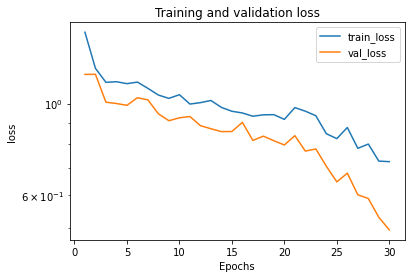

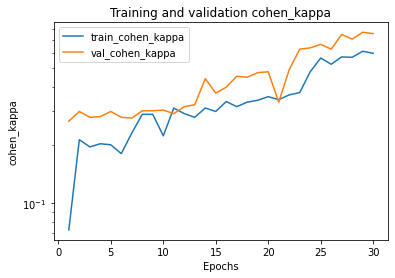

Evaluating Net...
Training Net with learning rate: 0.00068
Epoch 26: early stopping
Training metrics for learning rate: 0.00068


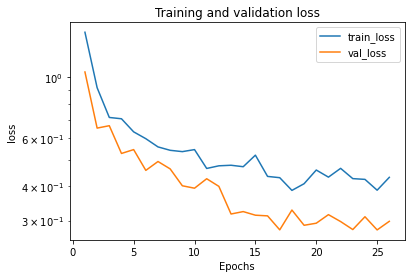

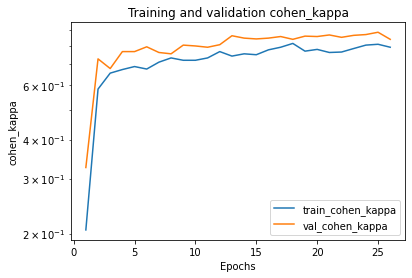

Evaluating Net...
Training Net with learning rate: 0.001
Epoch 26: early stopping
Training metrics for learning rate: 0.001


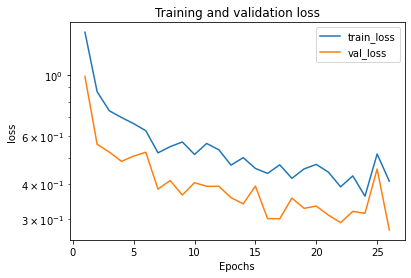

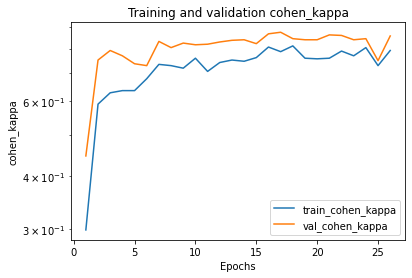

Evaluating Net...
Training Net with learning rate: 0.00147
Training metrics for learning rate: 0.00147


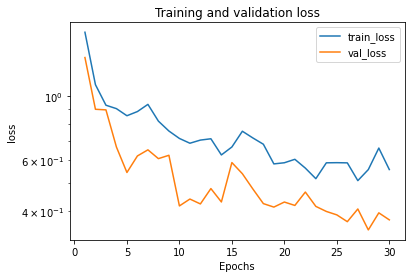

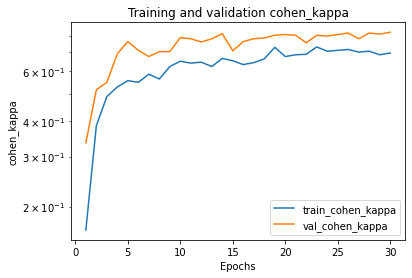

Evaluating Net...
Training Net with learning rate: 0.00215
Epoch 20: early stopping
Training metrics for learning rate: 0.00215


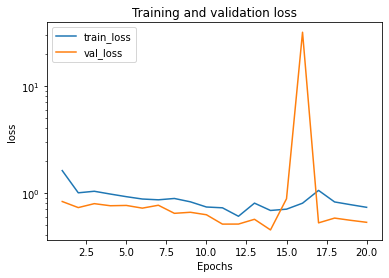

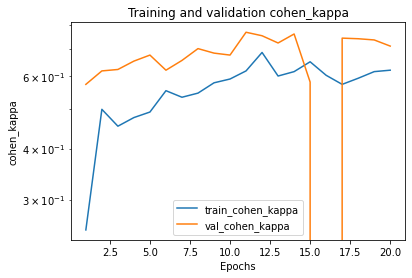

Evaluating Net...
Training Net with learning rate: 0.00316
Epoch 21: early stopping
Training metrics for learning rate: 0.00316


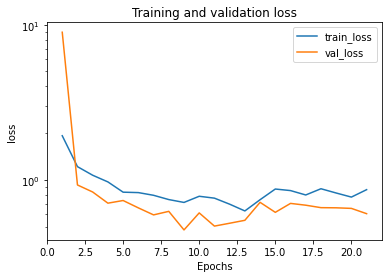

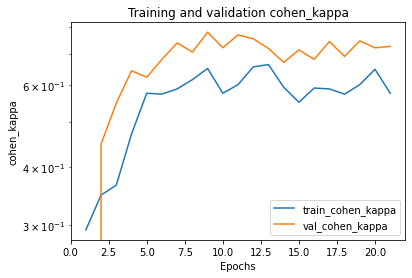

Evaluating Net...
Training Net with learning rate: 0.00464
Epoch 24: early stopping
Training metrics for learning rate: 0.00464


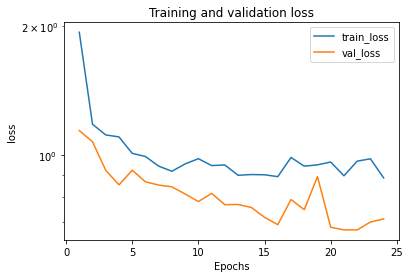

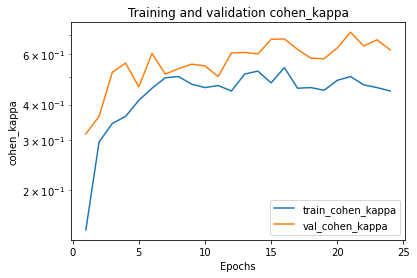

Evaluating Net...
Training Net with learning rate: 0.00681
Epoch 16: early stopping
Training metrics for learning rate: 0.00681


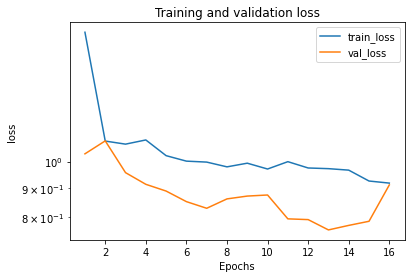

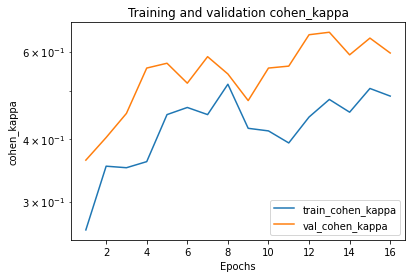

Evaluating Net...
Training Net with learning rate: 0.01
Epoch 14: early stopping
Training metrics for learning rate: 0.01


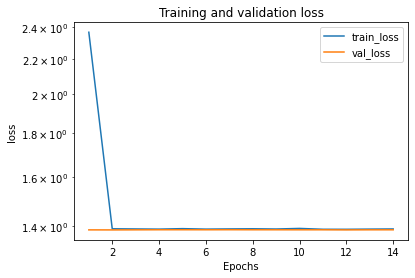

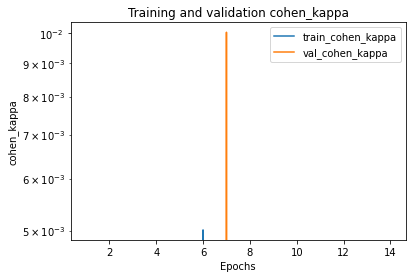

Evaluating Net...
Training Net with learning rate: 0.01468
Epoch 9: early stopping
Training metrics for learning rate: 0.01468


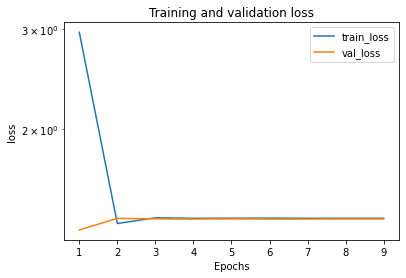

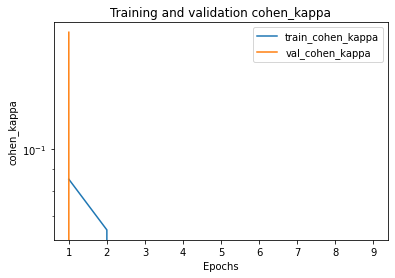

Evaluating Net...
Training Net with learning rate: 0.02154
Epoch 13: early stopping
Training metrics for learning rate: 0.02154


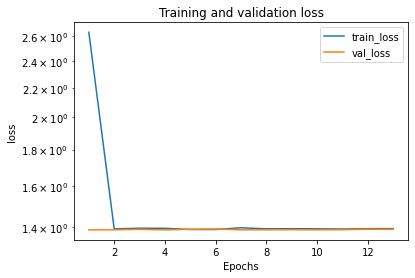

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  # Remove the CWD from sys.path while we load stuff.


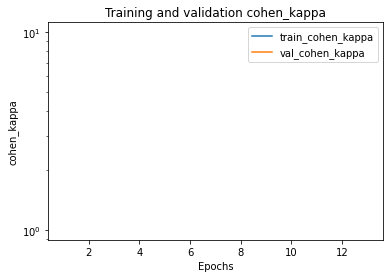

Evaluating Net...
Training Net with learning rate: 0.03162
Epoch 11: early stopping
Training metrics for learning rate: 0.03162


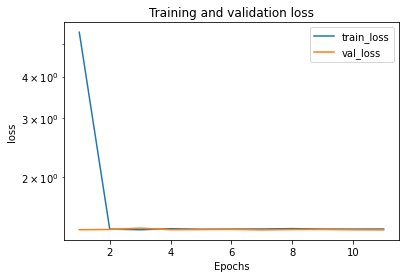

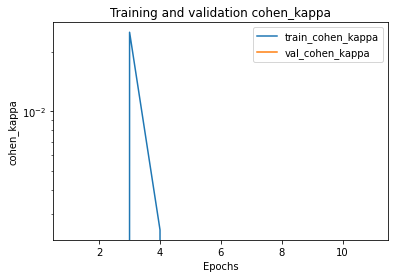

Evaluating Net...
Training Net with learning rate: 0.04642
Epoch 19: early stopping
Training metrics for learning rate: 0.04642


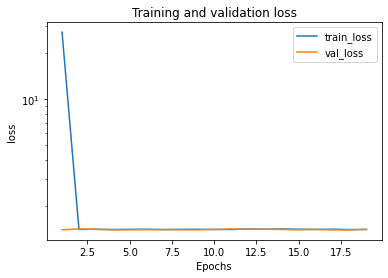

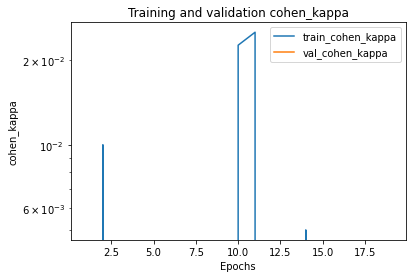

Evaluating Net...
Training Net with learning rate: 0.06813
Epoch 23: early stopping
Training metrics for learning rate: 0.06813


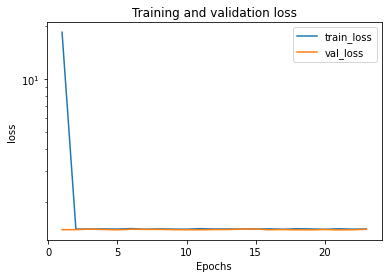

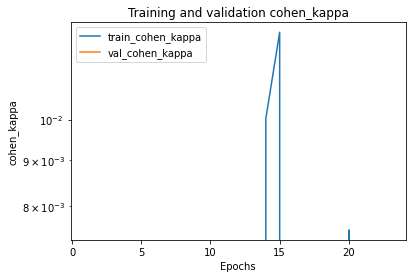

Evaluating Net...
Training Net with learning rate: 0.1
Epoch 20: early stopping


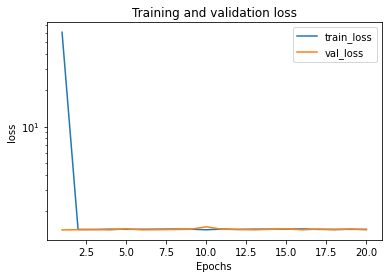

Training metrics for learning rate: 0.1


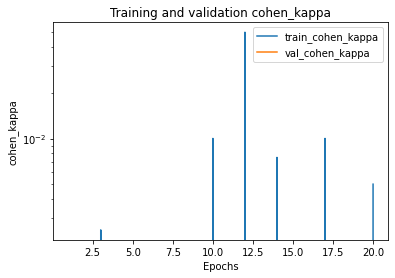

Evaluating Net...
Training Net with learning rate: 0.14678


In [ ]:
# Fitting all the CNN
"""
lr_selection = {'learning_rate':[],
                # 'model':[],
                'accuracy_train' : [],
                'accuracy_test':[],
                'kappa_train' : [],
                'kappa_test' : [],
                'epoch' : []
                }

for idx,lr in enumerate(lr_grid):
    lr_selection['learning_rate'].append(lr)
    
    # Load model - no compiled - weights 0
    model_lr = load_model(model_path)
    """
    """
    # Create model
    model_lr = keras.Sequential()
    model_lr.add(Dense(units = 32,input_dim = X_train.shape[1],activation='relu'))
    model_lr.add(Dropout(0.25))
    model_lr.add(Dense(units = 16,activation='relu'))
    model_lr.add(Dense(units = 2, activation='softmax'))
    """
    """

    # Compile the network
    optimizer = Adam(learning_rate=lr)
    model_lr.compile(optimizer= optimizer, #'adam', # 'rmsprop', # Optimization method
                  loss='categorical_crossentropy', # Error metric to minimize
                  metrics=['accuracy',CohenKappa(num_classes=4)]) # 'Precision','Recall', # Error metrics to report
    if idx == 0: print(model_lr.summary())
    
    # lr_selection['model'].append(model_lr)
    
    # Define callbacks
    # Checkpoints
    cp_path_lr = 'models/xRay_lr/xRay_aug_lr'+str(round(lr,5))+'.hdf5'
    cp_lr = ModelCheckpoint(
        filepath=cp_path_lr,
        monitor = 'val_cohen_kappa',
        mode = 'max',
        save_freq='epoch',
        save_weights_only=False,
        save_best_only = True,
        verbose=0
    )
    
    # EarlyStopping
    es_lr = EarlyStopping(monitor = "val_cohen_kappa", mode = 'max', # val_loss, # !!! "val_cohen_kappa"
                               patience=8, verbose=1)
    
    # Fit CNN
    print('Training Net with learning rate: %s...' %(round(lr,5)))
    history_lr = model_lr.fit(
        train_generator, 
        validation_data=val_generator,
        steps_per_epoch= train_generator.n//4, 
        epochs=30, 
        #validation_split=0.20, 
        #batch_size=15, 
        verbose=0,
        callbacks=[es_lr,cp_lr]
    )
    
    # This are the last values of the history ??? real metrics?
    # lr_selection['accuracy'].append(history_lr.history['accuracy'][-1])
    # lr_selection['val_accuracy'].append(history_lr.history['val_accuracy'][-1])
    lr_selection['epoch'].append(len(history_lr.history['accuracy']))
    
    # Plot training metrics
    print('Training metrics for learning rate: %s' %(round(lr,5)))
    plot_metric(history_lr,'loss')
    plot_metric(history_lr,'cohen_kappa')
    

    # Evaluate Model Train
    print('Evaluating Net...')
    eval_train_lr = model_lr.evaluate(load_validation,
                                      steps = load_validation.n//4,
                                      verbose = 0)
    
    lr_selection['accuracy_train'].append(eval_train_lr[model_lr.metrics_names.index('accuracy')])
    lr_selection['kappa_train'].append(eval_train_lr[model_lr.metrics_names.index('cohen_kappa')])

    # Evaluate Model Test
    eval_test_lr = model_lr.evaluate(test_generator,
                                      steps = test_generator.n//4,
                                      verbose = 0)
    
    lr_selection['accuracy_test'].append(eval_test_lr[model_lr.metrics_names.index('accuracy')])
    lr_selection['kappa_test'].append(eval_test_lr[model_lr.metrics_names.index('cohen_kappa')])

    


    # This is the code for the standard classification
    #y_pred_train_c3 = model_lr.predict(X_train) # This provides the probability for each class
    #y_pred_test_c3 = model_lr.predict(X_test) # This provides the probability for each class

    # !!! We need to extract for each row which is the class which the highest probability
    # which corresponds to the index of the sublist
    #y_pred_train_c3 = np.argmax(y_pred_train_c3, axis=1).reshape(-1,1)
    #y_pred_test_c3 = np.argmax(y_pred_test_c3, axis=1).reshape(-1,1)

    #model_performance_class(y_train, y_pred_train_c3, y_test, y_pred_test_c3)
    
    #lr_selection['kappa_train'].append(cohen_kappa_score(y_train, y_pred_train_c3))
    #lr_selection['kappa_test'].append(cohen_kappa_score(y_test, y_pred_test_c3))

"""

## Compare Models

In [ ]:
# Learning rate range
# 0.007 > lr > 0.00046
# It would be also possible to check lower rates
# indices 12 or 16:24(23)

In [ ]:
# Load trained CNN and compare Learning Rates


lr_selection = {'learning_rate':[],
                # 'model':[],
                'accuracy_train' : [],
                'accuracy_test':[],
                'kappa_train' : [],
                'kappa_test' : [],
                'epoch' : []
                }

for idx,lr in enumerate(lr_grid):
    lr_selection['learning_rate'].append(lr)
    
    # Load model - no compiled - weights 0
    # model_lr = load_model(model_path)
    
    """
    # Create model
    model_lr = keras.Sequential()
    model_lr.add(Dense(units = 32,input_dim = X_train.shape[1],activation='relu'))
    model_lr.add(Dropout(0.25))
    model_lr.add(Dense(units = 16,activation='relu'))
    model_lr.add(Dense(units = 2, activation='softmax'))
    """

    """
    # Compile the network
    optimizer = Adam(learning_rate=lr)
    model_lr.compile(optimizer= optimizer, #'adam', # 'rmsprop', # Optimization method
                  loss='categorical_crossentropy', # Error metric to minimize
                  metrics=['accuracy',CohenKappa(num_classes=4)]) # 'Precision','Recall', # Error metrics to report
    if idx == 0: print(model_lr.summary())
    
    # lr_selection['model'].append(model_lr)
    
    # Define callbacks
    # Checkpoints
    cp_path_lr = 'models/xRay_lr/xRay_aug_lr'+str(round(lr,5))+'.hdf5'
    cp_lr = ModelCheckpoint(
        filepath=cp_path_lr,
        save_freq='epoch',
        save_weights_only=False,
        save_best_only = True,
        verbose=0
    )
    
    # EarlyStopping
    es_lr = EarlyStopping(monitor = "cohen_kappa", mode = 'max', # val_loss, # !!! "val_cohen_kappa"
                               patience=8, verbose=1)
    
    # Fit CNN
    print('Training Net with learning rate: %s...' %(round(lr,5)))
    history_lr = model_lr.fit(
        train_generator, 
        validation_data=val_generator,
        steps_per_epoch= train_generator.n//4, 
        epochs=30, 
        #validation_split=0.20, 
        #batch_size=15, 
        verbose=0,
        callbacks=[es_lr,cp_lr])

    
    # This are the last values of the history ??? real metrics?
    # lr_selection['accuracy'].append(history_lr.history['accuracy'][-1])
    # lr_selection['val_accuracy'].append(history_lr.history['val_accuracy'][-1])
    lr_selection['epoch'].append(len(history_lr.history['accuracy']))
    
    # Plot training metrics
    print('Training metrics for learning rate: %s' %(round(lr,5)))
    plot_metric(history_lr,'loss')
    plot_metric(history_lr,'cohen_kappa')
    """

    # Load model - compiled - weights ok
    cp_path_lr = 'models/xRay_lr/xRay_aug_lr'+str(round(lr,5))+'.hdf5'
    model_lr = load_model(cp_path_lr)

    # Evaluate Model Train
    print('Evaluating Net...')
    eval_train_lr = model_lr.evaluate(load_validation,
                                      steps = load_validation.n//4,
                                      verbose = 0)
    
    lr_selection['accuracy_train'].append(eval_train_lr[model_lr.metrics_names.index('accuracy')])
    lr_selection['kappa_train'].append(eval_train_lr[model_lr.metrics_names.index('cohen_kappa')])

    # Evaluate Model Test
    eval_test_lr = model_lr.evaluate(test_generator,
                                      steps = test_generator.n//4,
                                      verbose = 0)
    
    lr_selection['accuracy_test'].append(eval_test_lr[model_lr.metrics_names.index('accuracy')])
    lr_selection['kappa_test'].append(eval_test_lr[model_lr.metrics_names.index('cohen_kappa')])

    


    # This is the code for the standard classification
    #y_pred_train_c3 = model_lr.predict(X_train) # This provides the probability for each class
    #y_pred_test_c3 = model_lr.predict(X_test) # This provides the probability for each class

    # !!! We need to extract for each row which is the class which the highest probability
    # which corresponds to the index of the sublist
    #y_pred_train_c3 = np.argmax(y_pred_train_c3, axis=1).reshape(-1,1)
    #y_pred_test_c3 = np.argmax(y_pred_test_c3, axis=1).reshape(-1,1)

    #model_performance_class(y_train, y_pred_train_c3, y_test, y_pred_test_c3)
    
    #lr_selection['kappa_train'].append(cohen_kappa_score(y_train, y_pred_train_c3))
    #lr_selection['kappa_test'].append(cohen_kappa_score(y_test, y_pred_test_c3))



Evaluating Net...
Evaluating Net...
Evaluating Net...
Evaluating Net...
Evaluating Net...
Evaluating Net...
Evaluating Net...
Evaluating Net...
Evaluating Net...
Evaluating Net...
Evaluating Net...
Evaluating Net...
Evaluating Net...
Evaluating Net...
Evaluating Net...
Evaluating Net...


In [ ]:
del lr_selection['epoch']

In [ ]:
lr_selection.keys()

dict_keys(['learning_rate', 'accuracy_train', 'accuracy_test', 'kappa_train', 'kappa_test'])

In [ ]:
lr_selection['learning_rate']

[0.00046415888336127773,
 0.0006812920690579609,
 0.001,
 0.0014677992676220691,
 0.002154434690031882,
 0.0031622776601683794,
 0.004641588833612777,
 0.006812920690579608,
 0.01,
 0.014677992676220676,
 0.021544346900318822,
 0.03162277660168379,
 0.046415888336127725,
 0.06812920690579609,
 0.1,
 0.14677992676220675]

In [ ]:
lr_selection_df = pd.DataFrame(lr_selection)
lr_selection_df

,learning_rate,accuracy_train,accuracy_test,kappa_train,kappa_test
0,0.000464,0.769231,0.775,0.692308,0.700000
1,0.000681,0.913462,0.850,0.884615,0.800000
2,0.001000,0.884615,0.850,0.846154,0.800000
3,0.001468,0.865385,0.800,0.820513,0.733333
4,0.002154,0.798077,0.725,0.730769,0.633333
5,0.003162,0.855769,0.750,0.807692,0.666667
6,0.004642,0.750000,0.750,0.666667,0.666667
7,0.006813,0.798077,0.675,0.730769,0.566667
8,0.010000,0.250000,0.250,0.000000,0.000000
9,0.014678,0.394231,0.325,0.192308,0.100000


In [ ]:
lr_selection_df.to_csv('models/xRay_lr/xRay_aug_lr.csv')

## Best Models

In [ ]:
lr_selection_df[lr_selection_df.kappa_test==lr_selection_df.kappa_test.max()]

,learning_rate,accuracy_train,accuracy_test,kappa_train,kappa_test
1,0.000681,0.913462,0.85,0.884615,0.8
2,0.001000,0.884615,0.85,0.846154,0.8


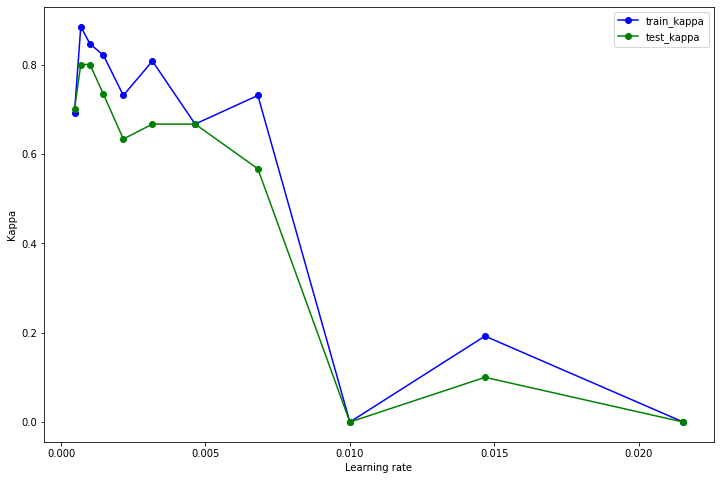

In [ ]:
fig, ax = plt.subplots(figsize=(12,8)) #,dpi=200)
ax.plot(lr_selection_df.learning_rate[:11], lr_selection_df.kappa_train[:11], 'b', marker='o', label = 'train')
ax.plot(lr_selection_df.learning_rate[:11], lr_selection_df.kappa_test[:11], 'g', marker='o', label = 'test')
ax.set_xlabel("Learning rate")
ax.set_ylabel("Kappa")
plt.legend(["train_kappa", 'test_kappa'])
plt.show()

In [ ]:
# The best learning rate would be 0.001

# Test Learning Function

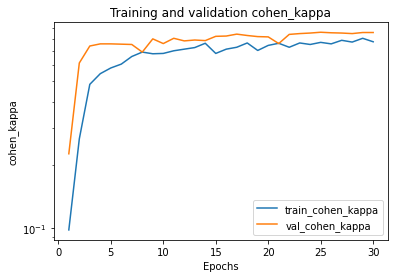

In [ ]:
"""
plot_metric(history_lr,'cohen_kappa')
    

# Evaluate Model Train
eval_train_lr = model_lr.evaluate(load_validation,
                                      steps = load_validation.n//4,
                                      verbose = 0)
    
lr_selection['accuracy_train'].append(eval_train_lr[model_lr.metrics_names.index('accuracy')])
lr_selection['kappa_train'].append(eval_train_lr[model_lr.metrics_names.index('cohen_kappa')])

# Evaluate Model Test
eval_test_lr = model_lr.evaluate(test_generator,
                                      steps = test_generator.n//4,
                                      verbose = 0)
    
lr_selection['accuracy_test'].append(eval_test_lr[model_lr.metrics_names.index('accuracy')])
lr_selection['kappa_test'].append(eval_test_lr[model_lr.metrics_names.index('cohen_kappa')])
"""

In [ ]:
# lr_selection

{'accuracy_test': [0.7749999761581421],
 'accuracy_train': [0.8942307829856873],
 'epoch': [30],
 'kappa_test': [0.7000000476837158],
 'kappa_train': [0.8589743375778198],
 'learning_rate': [0.00046415888336127773]}

# Test Load Model

In [ ]:
#cls_test = load_model(model_path)

In [ ]:
#cls_test.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
#            metrics=['accuracy','Precision','Recall',CohenKappa(num_classes=4)])

In [ ]:
# cls_test.summary()